KeyboardInterrupt: 

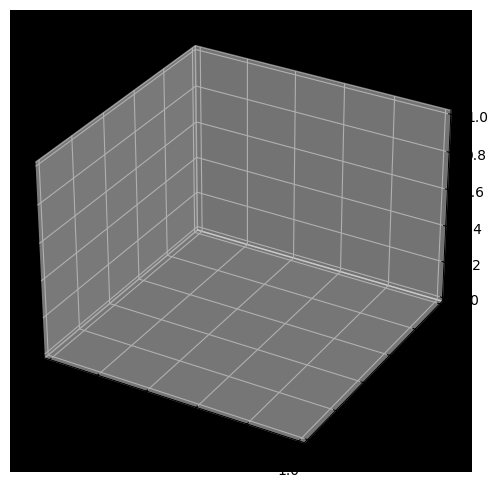

: 

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import time
import math

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, model_complexity=0, smooth_landmarks=True, 
                     min_detection_confidence=0.5, min_tracking_confidence=0.5)

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

POSE_CONNECTIONS = [(11, 12), (11, 13), (13, 15), (12, 14), (14, 16),
                    (11, 23), (12, 24), (23, 24), (23, 25), (24, 26),
                    (25, 27), (26, 28), (27, 31), (28, 32)]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('black')
plt.ion()

start_time = time.time()
frame_count = 0
trail_points = []
max_trail_length = 8

def get_gradient_color(t):
    hue = (t * 120) % 360
    c = 1
    x = c * (1 - abs((hue / 60) % 2 - 1))
    
    if 0 <= hue < 60:
        r, g, b = c, x, 0
    elif 60 <= hue < 120:
        r, g, b = x, c, 0
    elif 120 <= hue < 180:
        r, g, b = 0, c, x
    elif 180 <= hue < 240:
        r, g, b = 0, x, c
    elif 240 <= hue < 300:
        r, g, b = x, 0, c
    else:
        r, g, b = c, 0, x
    
    return (int(r * 255), int(g * 255), int(b * 255))

def draw_smooth_line(img, pt1, pt2, color, thickness):
    cv2.line(img, pt1, pt2, color, thickness)
    cv2.line(img, pt1, pt2, tuple(c//2 for c in color), thickness+2)

def draw_smooth_circle(img, center, radius, color):
    cv2.circle(img, center, radius, color, -1)
    cv2.circle(img, center, radius//2, (255, 255, 255), -1)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    frame = cv2.flip(frame, 1)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(frame_rgb)
    
    current_time = time.time()
    wave_time = current_time - start_time
    
    gradient_color = get_gradient_color(wave_time)
    pulse_intensity = 0.8 + 0.2 * math.sin(wave_time * 6)
    neon_color = tuple(int(c * pulse_intensity) for c in gradient_color)
    
    if results.pose_landmarks:
        height, width, _ = frame.shape
        
        # Only calculate clone landmarks (mirrored)
        clone_landmarks_2d = [(int((1 - lm.x) * width), int(lm.y * height)) for lm in results.pose_landmarks.landmark]
        clone_landmarks_3d = [(1 - lm.x, lm.y, lm.z) for lm in results.pose_landmarks.landmark]
        
        glow_layer = np.zeros_like(frame, dtype=np.uint8)
        
        # Draw clone connections with smooth lines
        for i, j in POSE_CONNECTIONS:
            x1, y1 = clone_landmarks_2d[i]
            x2, y2 = clone_landmarks_2d[j]
            
            thickness = 6
            draw_smooth_line(glow_layer, (x1, y1), (x2, y2), neon_color, thickness)
        
        clone_joint_points = []
        
        # Draw clone joints
        for idx, (x, y) in enumerate(clone_landmarks_2d):
            if 0 <= x < width and 0 <= y < height:
                clone_joint_points.append((x, y))
                radius = 8
                draw_smooth_circle(glow_layer, (x, y), radius, neon_color)
        
        # Simplified trail effects
        trail_points.append(clone_joint_points.copy())
        if len(trail_points) > max_trail_length:
            trail_points.pop(0)
        
        for t_idx, trail_frame in enumerate(trail_points[:-1]):
            trail_alpha = (t_idx / len(trail_points)) * 0.4
            trail_color = tuple(int(c * trail_alpha) for c in neon_color)
            
            for x, y in trail_frame:
                if 0 <= x < width and 0 <= y < height:
                    cv2.circle(glow_layer, (x, y), 3, trail_color, -1)
        
        # Blend layers
        frame = cv2.addWeighted(frame, 0.7, glow_layer, 0.6, 0)
        
        # Update 3D plot less frequently
        if frame_count % 6 == 0:
            ax.clear()
            ax.set_xlim([-1, 1])
            ax.set_ylim([-1, 1])
            ax.set_zlim([-1, 1])
            ax.set_facecolor('black')
            ax.set_title("3D Clone", color='cyan', fontsize=12)
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])
            
            # Draw 3D clone
            line_color = tuple(c/255 for c in neon_color)
            for i, j in POSE_CONNECTIONS:
                x_vals, y_vals, z_vals = zip(clone_landmarks_3d[i], clone_landmarks_3d[j])
                ax.plot(x_vals, y_vals, z_vals, color=line_color, linewidth=3, alpha=0.8)
            
            for x, y, z in clone_landmarks_3d:
                ax.scatter(x, y, z, c=[line_color], s=50, alpha=0.8)
            
            plt.draw()
            plt.pause(0.001)
    
    else:
        # Simplified scanning message
        height, width, _ = frame.shape
        search_text = "SCANNING..."
        font_scale = 1.0
        thickness = 2
        text_size = cv2.getTextSize(search_text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)[0]
        text_x = (width - text_size[0]) // 2
        text_y = (height + text_size[1]) // 2
        
        scan_color = get_gradient_color(wave_time * 2)
        cv2.putText(frame, search_text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 
                   font_scale, scan_color, thickness)
    
    # Simple FPS counter
    if frame_count % 30 == 0:
        fps = int(1.0 / (time.time() - current_time + 0.001))
        fps_text = f"FPS: {fps}"
        cv2.putText(frame, fps_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
    cv2.imshow("CLONE TRACKER", frame)
    frame_count += 1
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
plt.ioff()
plt.close()